Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train for 628 steps, validate for 269 steps
Epoch 1/10
628/628 [==============================] - 145s 231ms/step - loss: 2.2202 - accuracy: 0.2123 - val_loss: 1.8026 - val_accuracy: 0.2566
Epoch 2/10
628/628 [==============================] - 52s 82ms/step - loss: 1.8669 - accuracy: 0.2540 - val_loss: 1.7940 - val_accuracy: 0.2543
Epoch 3/10
628/628 [==============================] - 53s 84ms/step - loss: 1.7508 - accuracy: 0.3043 - val_loss: 1.7476 - val_accuracy: 0.3095
Epoch 4/10
628/628 [==============================] - 51s 81ms/step - loss: 1.6761 - accuracy: 0.3372 - val_loss: 1.7588 - val_accuracy: 0.2756
Epoch 5/10
628/628 [==============================] - 52s 82ms/step - loss: 1.5938 - accuracy: 0.3792 - val_loss: 2.2099 - val_accuracy: 0.2363
Epoch 6/10
628/628 [==============================] - 52s 83ms/step - loss: 1.5382 - accuracy: 0.4002 - val

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


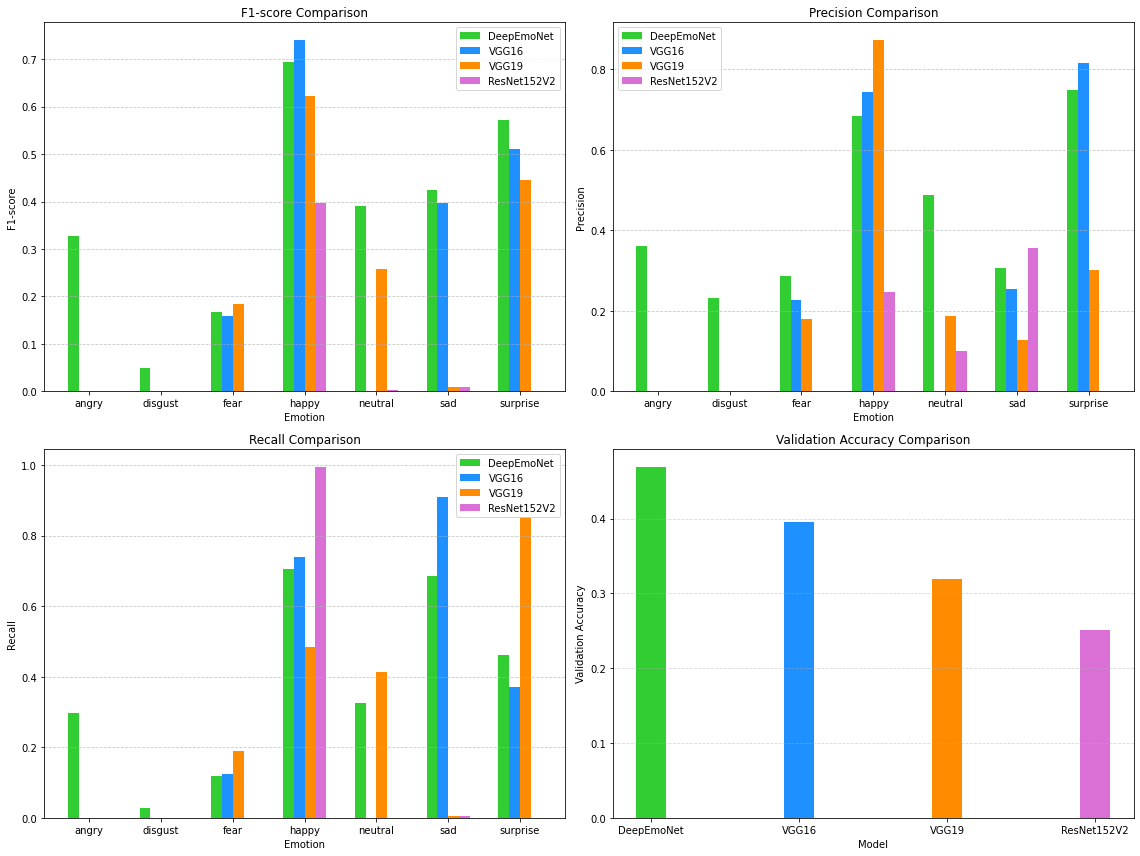

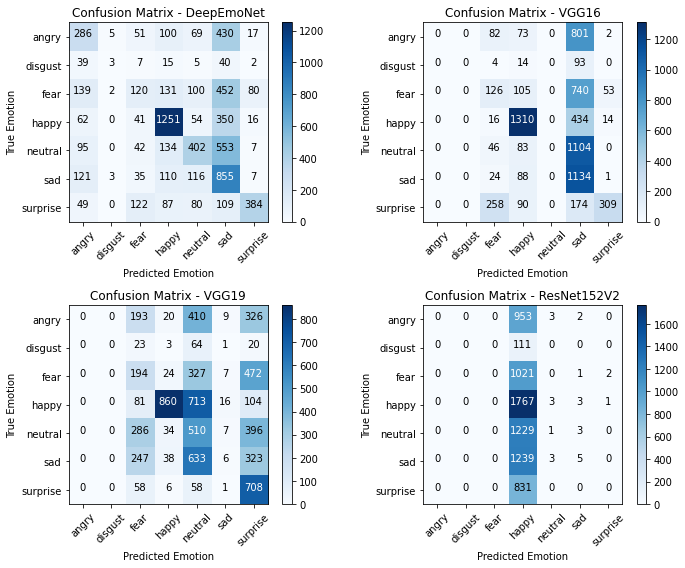

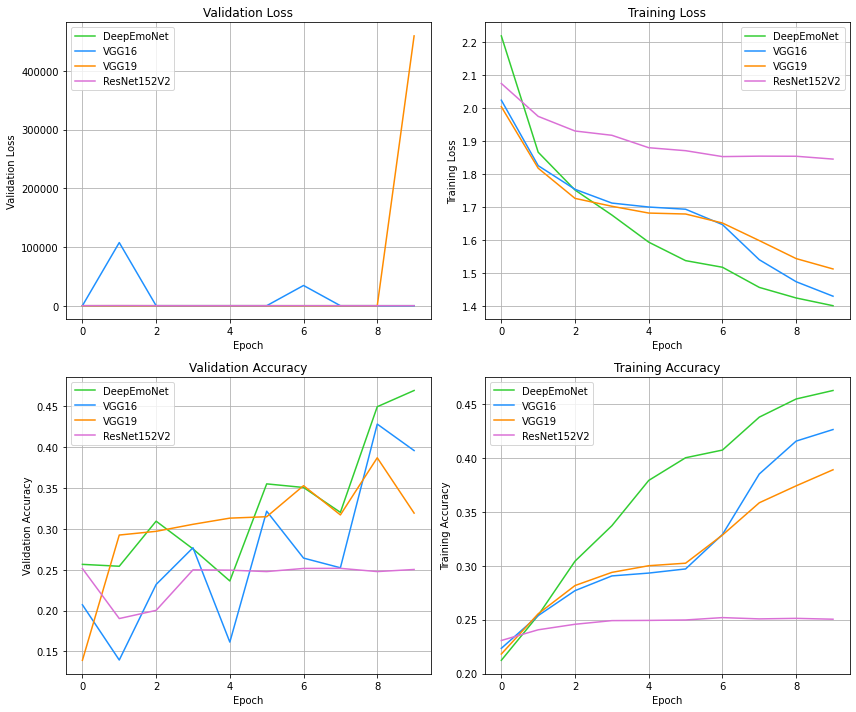

In [2]:
import os
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, VGG19, ResNet152V2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Constants
IMG_HEIGHT = 48
IMG_WIDTH = 48
NUM_CLASSES = 7
BATCH_SIZE = 32
EPOCHS = 10  # Increase the number of epochs for better training

def create_deepemonet(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model
# Function to create a VGG16 model
def create_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to create a ResNet152V2 model
def create_resnet152v2():  # Rename the function to create_resnet152v2
    base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model
# Function to create a VGG19 model
def create_vgg19():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Function to extract F1-score, precision, and recall from the classification report
def extract_metrics(classification_rep):
    class_names = list(validation_generator.class_indices.keys())
    f1_scores = [classification_rep[emotion]['f1-score'] for emotion in class_names]
    precisions = [classification_rep[emotion]['precision'] for emotion in class_names]
    recalls = [classification_rep[emotion]['recall'] for emotion in class_names]
    return f1_scores, precisions, recalls

# Function to calculate metrics (F1-score, precision, and recall)
def calculate_metrics(model, test_generator):
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    # Calculate confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)
    # Calculate classification report
    class_names = list(validation_generator.class_indices.keys())
    classification_rep = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    return confusion_mat, classification_rep

# Function to plot the confusion matrix
def plot_confusion_matrix(confusion_mat, emotions):
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(emotions))
    plt.xticks(tick_marks, emotions, rotation=45)
    plt.yticks(tick_marks, emotions)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')

    thresh = confusion_mat.max() / 2.0
    for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
        plt.text(j, i, format(confusion_mat[i, j], 'd'), horizontalalignment="center", color="white" if confusion_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


def train_with_early_stopping(model, train_gen, val_gen, epochs, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(filepath=f'/kaggle/working/{model_name}_best2.h5', monitor='val_loss', save_best_only=True)
    
    # Define the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
    
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // BATCH_SIZE,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=val_gen.samples // BATCH_SIZE,
        callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add ReduceLROnPlateau callback
    )
    return history

# Function to plot the confusion matrix for multiple models
def plot_multiple_confusion_matrices(confusion_mats, model_names, emotions):
    plt.figure(figsize=(10, 8))
    for i, confusion_mat in enumerate(confusion_mats):
        plt.subplot(2, 2, i + 1)
        plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {model_names[i]}')
        plt.colorbar()
        tick_marks = np.arange(len(emotions))
        plt.xticks(tick_marks, emotions, rotation=45)
        plt.yticks(tick_marks, emotions)
        plt.xlabel('Predicted Emotion')
        plt.ylabel('True Emotion')

        thresh = confusion_mat.max() / 2.0
        for j, k in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
            plt.text(k, j, format(confusion_mat[j, k], 'd'), horizontalalignment="center", color="white" if confusion_mat[j, k] > thresh else "black")

    plt.tight_layout()
    plt.show()

# Function to plot training history (loss and accuracy) for all models
def plot_training_history(model_histories, model_names, model_colors):
    num_models = len(model_histories)

    plt.figure(figsize=(12, 10))

    # Plot Validation Loss
    plt.subplot(2, 2, 1)
    for i, (history, model_name) in enumerate(zip(model_histories, model_names)):
        plt.plot(history.history['val_loss'], label=model_name, color=model_colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Training Loss
    plt.subplot(2, 2, 2)
    for i, (history, model_name) in enumerate(zip(model_histories, model_names)):
        plt.plot(history.history['loss'], label=model_name, color=model_colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    # Plot Validation Accuracy
    plt.subplot(2, 2, 3)
    for i, (history, model_name) in enumerate(zip(model_histories, model_names)):
        plt.plot(history.history['val_accuracy'], label=model_name, color=model_colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Training Accuracy
    plt.subplot(2, 2, 4)
    for i, (history, model_name) in enumerate(zip(model_histories, model_names)):
        plt.plot(history.history['accuracy'], label=model_name, color=model_colors[i])
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Set the random seed for reproducibility
tf.random.set_seed(42)

train_data_dir = '/kaggle/input/train'  # Replace with the path to your "train" folder
test_data_dir = '/kaggle/input/test'    # Replace with the path to your "test" folder

# Create an instance of the ImageDataGenerator with data augmentation and preprocessing
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3  # Use 30% of the data for validation
)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',  # Use 70% of the data for training
    shuffle=True
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  # Use 30% of the data for validation
    shuffle=False  # Do not shuffle the validation data to maintain order for confusion matrix
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Do not shuffle the test data to maintain order for the confusion matrix
)

# Define class names
class_names = list(train_generator.class_indices.keys())

# Create DeepEmoNet, VGG16, VGG19, and ResNet152V2 models
deepemonet_model = create_deepemonet(IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES)
vgg16_model = create_vgg16()
vgg19_model = create_vgg19()
resnet152v2_model = create_resnet152v2()  # Use create_resnet152v2 to create the ResNet152V2 model

# Compile the models
deepemonet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet152v2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Use resnet152v2_model

# Train the models with early stopping and save the best model
deepemonet_history = train_with_early_stopping(deepemonet_model, train_generator, validation_generator, EPOCHS, model_name='deepemonet')
vgg16_history = train_with_early_stopping(vgg16_model, train_generator, validation_generator, EPOCHS, model_name='vgg16')
vgg19_history = train_with_early_stopping(vgg19_model, train_generator, validation_generator, EPOCHS, model_name='vgg19')
resnet152v2_history = train_with_early_stopping(resnet152v2_model, train_generator, validation_generator, EPOCHS, model_name='resnet152v2')  # Use resnet152v2_history

# Calculate metrics for all models
deepemonet_confusion_mat, deepemonet_classification_rep = calculate_metrics(deepemonet_model, test_generator)
vgg16_confusion_mat, vgg16_classification_rep = calculate_metrics(vgg16_model, test_generator)
vgg19_confusion_mat, vgg19_classification_rep = calculate_metrics(vgg19_model, test_generator)
resnet152v2_confusion_mat, resnet152v2_classification_rep = calculate_metrics(resnet152v2_model, test_generator)

# Extract F1-score, precision, and recall for all models
deepemonet_f1, deepemonet_precision, deepemonet_recall = extract_metrics(deepemonet_classification_rep)
vgg16_f1, vgg16_precision, vgg16_recall = extract_metrics(vgg16_classification_rep)
vgg19_f1, vgg19_precision, vgg19_recall = extract_metrics(vgg19_classification_rep)
resnet152v2_f1, resnet152v2_precision, resnet152v2_recall = extract_metrics(resnet152v2_classification_rep)

# Define colors for bars
deepemonet_color = 'limegreen'
vgg16_color = 'dodgerblue'
vgg19_color = 'darkorange'
resnet152v2_color = 'orchid'  # Add a new color for ResNet152v2

# Define model names for the bar plot
model_names = ['DeepEmoNet', 'VGG16', 'VGG19', 'ResNet152V2']

# Plot F1-score, precision, recall, and accuracy for all models on a single graph
plt.figure(figsize=(16, 12))

bar_width = 0.15
bar_positions = np.arange(len(class_names))

# Plot F1-score
plt.subplot(2, 2, 1)
plt.bar(bar_positions - 1.5 * bar_width, deepemonet_f1, width=bar_width, label='DeepEmoNet', align='center', color=deepemonet_color)
plt.bar(bar_positions - 0.5 * bar_width, vgg16_f1, width=bar_width, label='VGG16', align='center', color=vgg16_color)
plt.bar(bar_positions + 0.5 * bar_width, vgg19_f1, width=bar_width, label='VGG19', align='center', color=vgg19_color)
plt.bar(bar_positions + 1.5 * bar_width, resnet152v2_f1, width=bar_width, label='ResNet152V2', align='center', color=resnet152v2_color)
plt.xticks(bar_positions, class_names)
plt.xlabel('Emotion')
plt.ylabel('F1-score')
plt.title('F1-score Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Precision
plt.subplot(2, 2, 2)
plt.bar(bar_positions - 1.5 * bar_width, deepemonet_precision, width=bar_width, label='DeepEmoNet', align='center', color=deepemonet_color)
plt.bar(bar_positions - 0.5 * bar_width, vgg16_precision, width=bar_width, label='VGG16', align='center', color=vgg16_color)
plt.bar(bar_positions + 0.5 * bar_width, vgg19_precision, width=bar_width, label='VGG19', align='center', color=vgg19_color)
plt.bar(bar_positions + 1.5 * bar_width, resnet152v2_precision, width=bar_width, label='ResNet152V2', align='center', color=resnet152v2_color)
plt.xticks(bar_positions, class_names)
plt.xlabel('Emotion')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Recall
plt.subplot(2, 2, 3)
plt.bar(bar_positions - 1.5 * bar_width, deepemonet_recall, width=bar_width, label='DeepEmoNet', align='center', color=deepemonet_color)
plt.bar(bar_positions - 0.5 * bar_width, vgg16_recall, width=bar_width, label='VGG16', align='center', color=vgg16_color)
plt.bar(bar_positions + 0.5 * bar_width, vgg19_recall, width=bar_width, label='VGG19', align='center', color=vgg19_color)
plt.bar(bar_positions + 1.5 * bar_width, resnet152v2_recall, width=bar_width, label='ResNet152V2', align='center', color=resnet152v2_color)
plt.xticks(bar_positions, class_names)
plt.xlabel('Emotion')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot Accuracy
plt.subplot(2, 2, 4)
model_accuracies = [deepemonet_history.history['val_accuracy'][-1],
                    vgg16_history.history['val_accuracy'][-1],
                    vgg19_history.history['val_accuracy'][-1],
                    resnet152v2_history.history['val_accuracy'][-1]]

# Adjust the width of the bars to make them thicker
bar_width = 0.2 # You can increase this value to make the bars thicker
plt.bar(model_names, model_accuracies, width=bar_width, color=[deepemonet_color, vgg16_color, vgg19_color, resnet152v2_color])

plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Plot the confusion matrix for all models
confusion_mats = [deepemonet_confusion_mat, vgg16_confusion_mat, vgg19_confusion_mat, resnet152v2_confusion_mat]
model_names = ['DeepEmoNet', 'VGG16', 'VGG19', 'ResNet152V2']
plot_multiple_confusion_matrices(confusion_mats, model_names, emotions=class_names)

# Plot the training history for all models
model_colors = ['limegreen', 'dodgerblue', 'darkorange', 'orchid']  # Update with the colors you prefer
model_histories = [deepemonet_history, vgg16_history, vgg19_history, resnet152v2_history]
plot_training_history(model_histories, model_names, model_colors)


In [ ]:
INPUT_PATH = "/kaggle/input/fer2013/"

In [ ]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

In [ ]:
TOP_EMOTIONS = ["fear", "happy", "neutral", "angry", "surprise", "sad"]
total_images -= 28707
total_images

In [ ]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

In [ ]:
label_to_text

In [ ]:
fig = pyplot.figure(1, (8,8))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label==k)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(4,4,idx)
        ax.imshow(img[:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape

`Splitting the data into training and validation set.`

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
del img_arr
del img_label

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
batch_size = 25
epochs = 40

optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

In [ ]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [ ]:
label_to_text

In [ ]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

In [ ]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is not that good on other classes. One of the reason for this could be the fact that these classes have less data as compared to `happy`.

In [ ]:
np.random.seed(42)
fear_imgs = np.random.choice(np.where(y_test[:, text_to_label["fear"]]==1)[0], size=9, replace=False)
angry_imgs = np.random.choice(np.where(y_test[:, text_to_label["Angry"]]==1)[0], size=9, replace=False)

fig = pyplot.figure(1, (18, 4))

for i, (fear_idx, angry_idx) in enumerate(zip(fear_imgs, angry_imgs)):
        sample_img = X_test[fear_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:fear, p:{pred}")

        sample_img = X_test[angry_idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(2, 9, i+10)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:angry, p:{pred}")

        pyplot.tight_layout()

One of the reason for such low accuracy is the data quality. Below I have shown all the miss-classified images. Many of them doesn't belong to their true class but are actually looking more likely to the predicted class.

In [ ]:
def plot_miss_classified(emotion):
    miss_happy_indices = np.where((ytest_ != yhat_test) & (ytest_==text_to_label[emotion]))[0]
    print(f"total {len(miss_happy_indices)} miss labels out of {len(np.where(ytest_==text_to_label[emotion])[0])} for emotion {emotion}")

    cols = 15
    rows = math.ceil(len(miss_happy_indices) / cols)
    fig = pyplot.figure(1, (20, rows * 2))

    for i,idx in enumerate(miss_happy_indices):
        sample_img = X_test[idx,:,:,:]
        sample_img = sample_img.reshape(1,*sample_img.shape)
        pred = label_to_text[np.argmax(model.predict(sample_img), axis=1)[0]]

        ax = pyplot.subplot(rows,cols,i+1)
        ax.imshow(sample_img[0,:,:,0], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"p:{pred}")    

In [ ]:
plot_miss_classified(emotion="Happy")

As we see most of these are classified as `fear` the reason for that is that most of the fear mouths are opened as we see earlier and many of these mouths are opened like that.

In [ ]:
plot_miss_classified(emotion="fear")

In [ ]:
plot_miss_classified(emotion="Angry")

In [ ]:
plot_miss_classified(emotion="Neutral")